## Creating a Decision Tree Model for the Bigmart Data Set

In [116]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score
from math import sqrt

In [117]:
df = pd.read_csv("BigMart-Training-Data-refine.csv")      

### Handle all NA's

In [118]:
#Drop establishment year bc too many nulls and no significant effect
print(df.columns.values)
df = df.drop("Outlet_Establishment_Year",axis=1)
print(df.columns.values)

['Item_Weight' 'Item_Fat_Content' 'Item_Visibility' 'Item_Type' 'Item_MRP'
 'Outlet_Identifier' 'Outlet_Establishment_Year' 'Outlet_Size'
 'Outlet_Location_Type' 'Outlet_Type' 'Item_Outlet_Sales']
['Item_Weight' 'Item_Fat_Content' 'Item_Visibility' 'Item_Type' 'Item_MRP'
 'Outlet_Identifier' 'Outlet_Size' 'Outlet_Location_Type' 'Outlet_Type'
 'Item_Outlet_Sales']


In [119]:
#Fill in Item weight with average based on types
mapping = {}
for t in set(df["Item_Type"].values):
    arr = df[df["Item_Type"]==t]
    mean = round(arr["Item_Weight"].mean(),2)
    mapping[t] = mean

print(mapping)
print()

iw_ndx = list(df.columns.values).index("Item_Weight")
for i in range(0,len(df)):
    if np.isnan(df.iloc[i]["Item_Weight"]):
        t = df.iloc[i]["Item_Type"]
        df.iat[i, iw_ndx] = mapping[t]

nulls = len(df[df["Item_Weight"].isnull()])
print("Item_Weight:\n% Nulls: {}".format(100*nulls/len(df)))

{'Baking Goods': 12.28, 'Household': 13.38, 'Hard Drinks': 11.4, 'Meat': 12.82, 'Snack Foods': 12.99, 'Starchy Foods': 13.69, 'Seafood': 12.55, 'Dairy': 13.43, 'Frozen Foods': 12.87, 'Breakfast': 12.77, 'Soft Drinks': 11.85, 'Health and Hygiene': 13.14, 'Breads': 11.35, 'Fruits and Vegetables': 13.22, 'Canned': 12.31, 'Others': 13.85}

Item_Weight:
% Nulls: 0.0


In [120]:
#Fill in a guessed value for Outlet_size based on location_type & type
null_outlets = set(df[df["Outlet_Size"].isnull()]["Outlet_Identifier"].values)
for outlet in null_outlets:
    arr = df[df["Outlet_Identifier"] == outlet]
    ltype = list(set(arr["Outlet_Location_Type"].values))
    otype = list(set(arr["Outlet_Type"].values))
    temp = df[df["Outlet_Location_Type"]==ltype[0]]
    temp = temp[temp["Outlet_Type"]==otype[0]]
    frequencies = temp["Outlet_Size"].value_counts()
    print(otype+ltype)
    print(frequencies)
    print()

print(null_outlets)
outlet_mapping = {"45": "Small", "10":"Medium", "17":"Small"}
print(outlet_mapping)
print("Used mode for similar stores where applicable and used overall mode if no data available")

['Supermarket Type1', 2]
Small    930
Name: Outlet_Size, dtype: int64

['Supermarket Type1', 2]
Small    930
Name: Outlet_Size, dtype: int64

['Grocery Store', 3]
Series([], Name: Outlet_Size, dtype: int64)

{'17', '45', '10'}
{'45': 'Small', '10': 'Medium', '17': 'Small'}
Used mode for similar stores where applicable and used overall mode if no data available


In [121]:
os_ndx = list(df.columns.values).index("Outlet_Size")
for i in range(0,len(df)):
    cur = df.iloc[i]["Outlet_Size"]
    if type(cur) != str:
        if np.isnan(df.iloc[i]["Outlet_Size"]):
            val = outlet_mapping[str(df.iloc[i]["Outlet_Identifier"])]
            df.iat[i,os_ndx] = val
print(set(df["Outlet_Size"].values))

{'Small', 'High', 'Medium'}


#### One final peak just to see how everything looks

In [122]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low_Fat,0.016047,Dairy,249.8092,49,Medium,1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,3,Supermarket Type2,443.4228
2,17.50,Low_Fat,0.016760,Meat,141.6180,49,Medium,1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,10,Medium,3,Grocery Store,732.3800
4,8.93,Low_Fat,0.000000,Household,53.8614,13,High,3,Supermarket Type1,994.7052


### Line to convert to dummies

In [123]:
#Populate with all categorical variables
cat_list = df.select_dtypes(include=['object']).columns.tolist()
cat_list.append("Outlet_Location_Type") #This gets accidentally ignored bc its already numeric
dummy_df = pd.get_dummies(df,columns=cat_list)
dummy_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Fat_Content_Low_Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Location_Type_1,Outlet_Location_Type_2,Outlet_Location_Type_3
0,9.30,0.016047,249.8092,3735.1380,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
1,5.92,0.019278,48.2692,443.4228,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2,17.50,0.016760,141.6180,2097.2700,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
3,19.20,0.000000,182.0950,732.3800,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
4,8.93,0.000000,53.8614,994.7052,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


### Prepping for Decision Tree Model

In [124]:
X = dummy_df.drop("Item_Outlet_Sales",axis=1) #Populate this to be the df with all features EXCEPT TARGET
Y = df["Item_Outlet_Sales"] #Populate this to be the df with ONLY TARGET
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 100)

### Training the Model

In [161]:
model = DecisionTreeRegressor(max_depth=7,min_samples_leaf=5)
#Chose some low arbitrary values for these parameters to prevent a memory crash
model = model.fit(X_train,y_train)
model

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Performing a Prediction

In [162]:
y_pred = model.predict(X_test)

### Calculate Model's Accuracy

In [163]:
# y_true = y_test.as_matrix()
# accuracy = accuracy_score(y_true,y_pred)
# print("Our Model's Accuracy is: {}".format(round(accuracy,2)*100))
print("This is not a simple classification so there is no simple percentage accuracy to be calculated")

This is not a simple classification so there is no simple percentage accuracy to be calculated


### Calculate's Model's R^2

In [164]:
score = model.score(X_test,y_test)
print("Our Models' R^2 is: {}".format(score))

Our Models' R^2 is: 0.5767920218491476


### Calculate Model's Root Mean Sq. Error

In [165]:
N = len(y_pred)
# y_test = y_test.as_matrix()
temp = [(y_pred[i]-y_test[i])**2 for i in range(0,N)]
total = sum(temp)
rmse = sqrt(total/N)
print("Our Root Mean Square Error is: {}".format(rmse))

Our Root Mean Square Error is: 1095.6431456478315


### Plotting Results

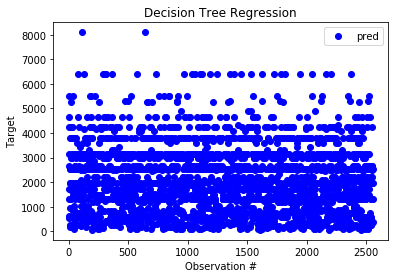

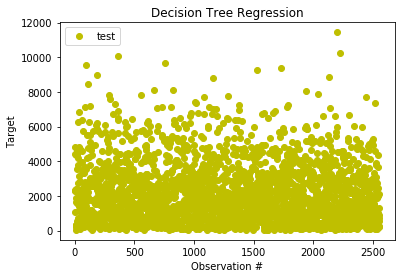

In [166]:
plt.figure()
X = [x for x in range(0,N)]
plt.plot(X, y_pred,'bo', label="pred")
plt.xlabel("Observation #")
plt.ylabel("Target")
plt.title("Decision Tree Regression")
plt.legend()
plt.figure()
plt.plot(X, y_test, 'yo', label="test")
plt.xlabel("Observation #")
plt.ylabel("Target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [176]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low_Fat,0.016047,Dairy,249.8092,49,Medium,1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,3,Supermarket Type2,443.4228
2,17.50,Low_Fat,0.016760,Meat,141.6180,49,Medium,1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,10,Medium,3,Grocery Store,732.3800
4,8.93,Low_Fat,0.000000,Household,53.8614,13,High,3,Supermarket Type1,994.7052
